# Entrenamiento de KNN comparando con Hu Moments y Zernike Moments

Realizado por: Justin Lucero, Jhonatan Tacuri


In [2]:
import os
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
import mahotas
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[Dolphin]
PreviewsShown=true
Timestamp=2020,8,25,15,24,17
Version=4


## Visualizacion de dataSet 

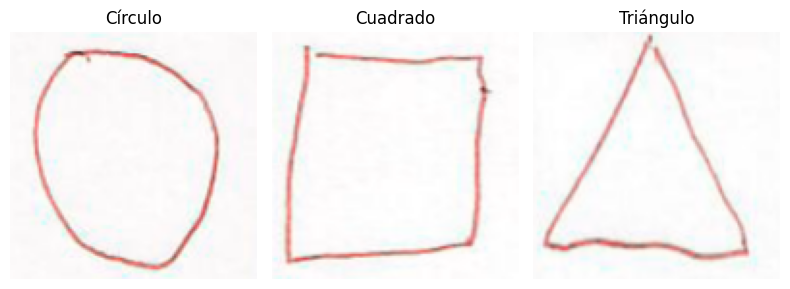

In [3]:
def mostrar_una(ruta):
    archivos = os.listdir(ruta)
    archivo = random.choice(archivos)
    
    path = os.path.join(ruta, archivo)
    img = cv.imread(path)
    img = cv.resize(img, (128, 128))
    
    return img
imgCir = mostrar_una("ups-writing-skills/all-images/circle")
imgCua = mostrar_una("ups-writing-skills/all-images/square")
imgTri = mostrar_una("ups-writing-skills/all-images/triangle")

plt.figure(figsize=(8,5))

plt.subplot(1,3,1)
plt.imshow(imgCir)
plt.title("Círculo")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(imgCua)
plt.title("Cuadrado")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(imgTri)
plt.title("Triángulo")
plt.axis("off")

plt.tight_layout()
plt.show()


### Se binariza la imagen 

In [4]:

def cargarIMG(ruta,label):
    imgs = []
    labels = []
    for archivo in os.listdir(ruta):
        img = cv.imread(ruta+"/"+archivo)
        img = cv.resize(img, (128, 128))
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
        _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        imgs.append(bin_img)
        labels.append(label)
    return imgs,labels



imgsOrgCir,labelCir = cargarIMG("ups-writing-skills/all-images/circle",0)
imgsOrgCua,labelCua = cargarIMG("ups-writing-skills/all-images/square",1)
imgsOrgTri,labelTri = cargarIMG("ups-writing-skills/all-images/triangle",2)

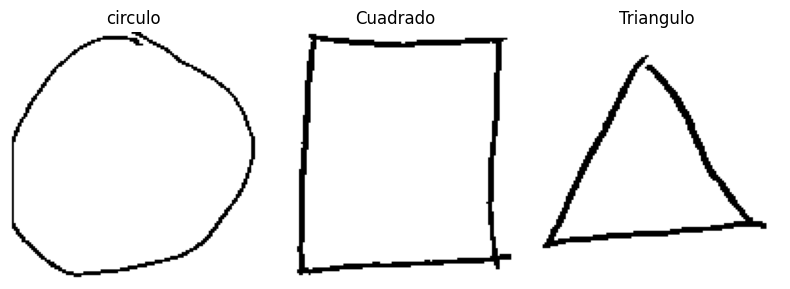

In [5]:
plt.figure(figsize=(8,5))

plt.subplot(1,3,1)
plt.imshow(imgsOrgCir[1], cmap='gray')
plt.title("circulo")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(imgsOrgCua[1], cmap='gray')
plt.title("Cuadrado")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(imgsOrgTri[1], cmap='gray')
plt.title("Triangulo")
plt.axis("off")

plt.tight_layout()
plt.show()


## Inyección de Ruido con ruido Gaussian y Salt & Pepper

In [10]:
def injectionNoise(imgs,gaussiano=5,sp = 0.01):
    imgsRuido = []
    for img in imgs:
        # Ruido gaussiano
        ruido = np.zeros(img.shape, dtype=np.float32)
        cv.randn(ruido, mean=0, stddev=gaussiano)

        img_float = img.astype(np.float32)

        img_ruido = img_float + ruido

        img_ruido = np.clip(img_ruido, 0, 255).astype(np.uint8)

        # Ruido Sal y pimienta, y no fuimo
        h, w = img_ruido.shape[:2]
        num_pixeles = int(sp * h * w)

        for _ in range(num_pixeles // 2):
            y = np.random.randint(0, h)
            x = np.random.randint(0, w)
            img_ruido[y, x] = 255

        for _ in range(num_pixeles // 2):
            y = np.random.randint(0, h)
            x = np.random.randint(0, w)
            img_ruido[y, x] = 0
        imgsRuido.append(img_ruido)
        
    return imgsRuido
    

In [11]:
imgsRuidoBajTri = injectionNoise(imgsOrgTri)
imgsRuidoMedTri = injectionNoise(imgsOrgTri,15,0.05)
imgsRuidoAltTri = injectionNoise(imgsOrgTri,30,0.1)

imgsRuidoBajCir = injectionNoise(imgsOrgCir)
imgsRuidoMedCir = injectionNoise(imgsOrgCir,15,0.05)
imgsRuidoAltCir = injectionNoise(imgsOrgCir,30,0.1)

imgsRuidoBajCua = injectionNoise(imgsOrgCua)
imgsRuidoMedCua = injectionNoise(imgsOrgCua,15,0.05)
imgsRuidoAltCua = injectionNoise(imgsOrgCua,30,0.1)


### Visualizacion de niveles de ruido

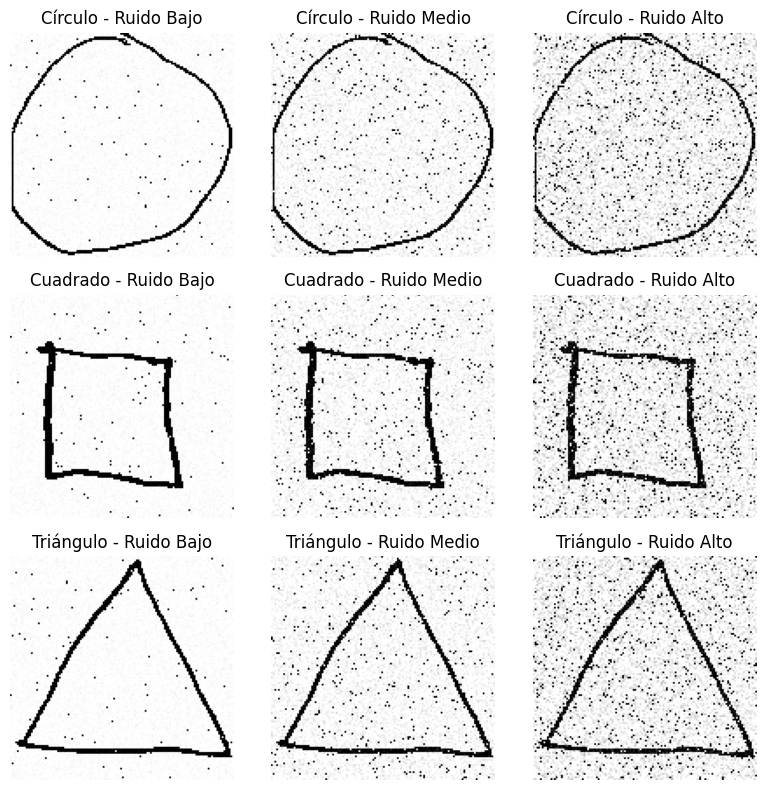

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

imagenes = [
    [imgsRuidoBajCir[1], imgsRuidoMedCir[1], imgsRuidoAltCir[1]],
    [imgsRuidoBajCua[2], imgsRuidoMedCua[2], imgsRuidoAltCua[2]],
    [imgsRuidoBajTri[3], imgsRuidoMedTri[3], imgsRuidoAltTri[3]]
]

titulos = ["Círculo", "Cuadrado", "Triángulo"]
niveles = ["Ruido Bajo", "Ruido Medio", "Ruido Alto"]
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(imagenes[i][j] , cmap='gray')
        axs[i, j].set_title(f"{titulos[i]} - {niveles[j]}")
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()


### Rotacion de imagenes

In [13]:
def rotacionImgs(imgs):
    imgsRot= []

    for img in imgs:
        h, w = img.shape[:2]
        centro = (w // 2, h // 2)

        angulo = random.uniform(0, 360)

        M = cv.getRotationMatrix2D(centro, angulo, 1.0)

        img_rotada = cv.warpAffine(img, M, (w, h), borderMode=cv.BORDER_CONSTANT, borderValue=(255, 255, 255))
        imgsRot.append(img_rotada)
    return imgsRot

In [14]:
imgsRotCir = rotacionImgs(imgsOrgCir)
imgsRotCua = rotacionImgs(imgsOrgCua)
imgsRotTri = rotacionImgs(imgsOrgTri)

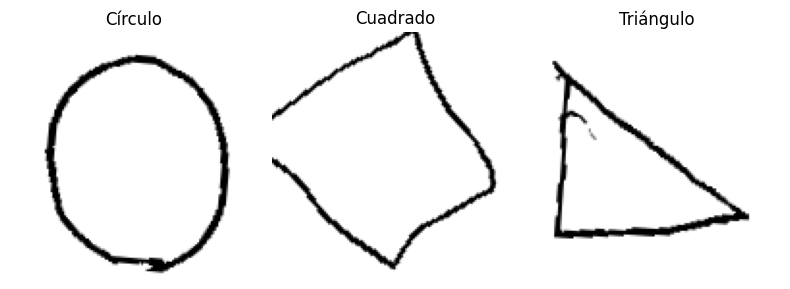

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(8, 8))

ania = [imgsRotCir[99], imgsRotCua[99], imgsRotTri[99]]

titulos = ["Círculo", "Cuadrado", "Triángulo"]
for i in range(3):
    axs[i].imshow(ania[i], cmap='gray')
    axs[i].set_title(f"{titulos[i]}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


#### Se unen todas las imagenes procesadas

In [16]:
imgsCircule = imgsOrgCir.copy()

imgsCircule.extend(imgsRuidoBajCir)
imgsCircule.extend(imgsRuidoMedCir)
imgsCircule.extend(imgsRuidoAltCir)

imgsCircule.extend(imgsRotCir)


In [17]:
imgsTriangle = imgsOrgTri.copy()

imgsTriangle.extend(imgsRuidoBajTri)
imgsTriangle.extend(imgsRuidoMedTri)
imgsTriangle.extend(imgsRuidoAltTri)

imgsTriangle.extend(imgsRotTri)


In [18]:
imgsSquare = imgsOrgCua.copy()

imgsSquare.extend(imgsRuidoBajCua)
imgsSquare.extend(imgsRuidoMedCua)
imgsSquare.extend(imgsRuidoAltCua)

imgsSquare.extend(imgsRotCua)

In [19]:
X_imgs = imgsCircule  + imgsSquare + imgsTriangle

y = (labelCir*5)+(labelCua*5)+(labelTri*5)

## Extracción de Características con Hu Moments y Zernike Moments

In [20]:
def hu_moments(img):
    # _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # moments = cv.moments(bin_img)
    moments = cv.moments(img)
    hu = cv.HuMoments(moments).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    return hu_log


In [21]:

def zernike_moments(img, radius=64, degree=8):
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    bin_img = bin_img // 255  # binaria 0/1
    return mahotas.features.zernike_moments(bin_img, radius, degree)


In [22]:
X_hu = []
X_zer = []

for img in X_imgs:
    
    X_hu.append(hu_moments(img))
    X_zer.append(zernike_moments(img))


## Entrenamiento del KNN y matrices de cofucion

### Con HU momements 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_hu, y, test_size=0.3)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test) 

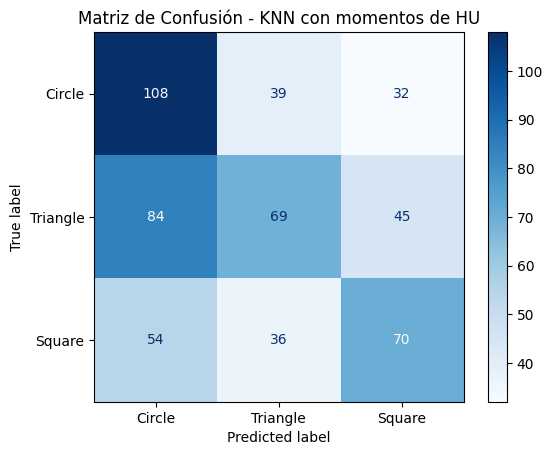

In [24]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Circle","Triangle","Square"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - KNN con momentos de HU")
plt.show()


### Con Zernike Moments

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_zer, y, test_size=0.3)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test) 

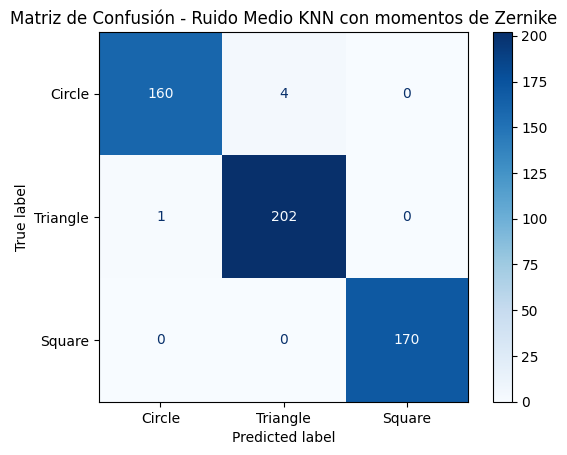

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Circle","Triangle","Square"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Ruido Medio KNN con momentos de Zernike")
plt.show()
